Explore a variety of policies for a simple multi-armed bandit

In [1]:
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from multiprocessing import Pool
from bandit import BinaryBandit
from policies import *
from utils import *

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

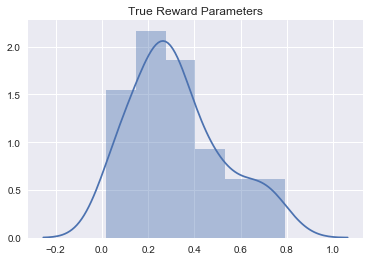

In [2]:
BB = BinaryBandit(K=50, a=2, b=3)
N_PLAYS = 10000
sns.distplot(BB.get_parameters())
plt.title("True Reward Parameters")

In [3]:
rewards = {}

First strategy: totally random.

In [4]:
outcomes, path, rewards["random"] = random_policy(BB, N_PLAYS)

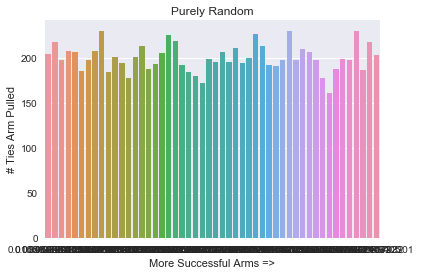

In [5]:
sns.barplot(x=sorted(BB.parameters),
            y=np.apply_along_axis(sum, 1, outcomes)[np.argsort(BB.parameters)])
plt.xlabel("More Successful Arms =>")
plt.ylabel("# Ties Arm Pulled")
plt.title("Purely Random")

In [6]:
regret(BB.parameters, outcomes)

0.46814682230058363

Somewhat more sophisticated strategy: $\epsilon$-greedy

In [7]:
outcomes, path, rewards["epsilon0.1"] = epsilon_greedy_policy(BB, N_PLAYS, 0.1)

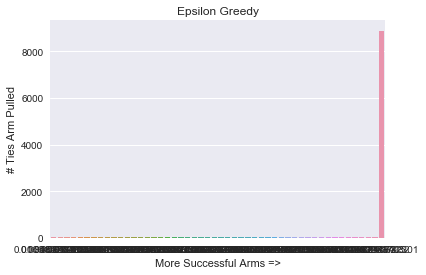

In [8]:
sns.barplot(x=sorted(BB.parameters),
            y=np.apply_along_axis(sum, 1, outcomes)[np.argsort(BB.parameters)])
plt.xlabel("More Successful Arms =>")
plt.ylabel("# Ties Arm Pulled")
plt.title("Epsilon Greedy")

In [9]:
regret(BB.parameters, outcomes)

0.058346822300583606

Wow! This approach really liked one of the arms. Which one, and how good is it?

In [10]:
BB.parameters[np.argmax(np.apply_along_axis(sum, 1, outcomes))]

0.79224682230058363

In [11]:
max(BB.parameters)

0.79224682230058363

## Boltzmann exploration

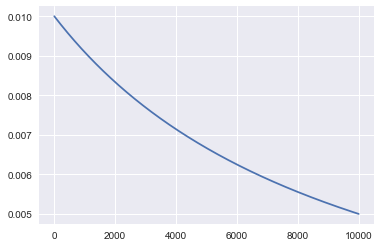

In [12]:
# need to choose a temperature function for Boltzmann exploration
# this one looks good enough
def temp(t):
    return 100 / (N_PLAYS + t)
t = range(N_PLAYS)
T = [temp(s) for s in range(N_PLAYS)]
plt.plot(t, T)

In [13]:
outcomes, path, rewards["boltzmann"] = boltzmann_policy(BB, N_PLAYS, temp)

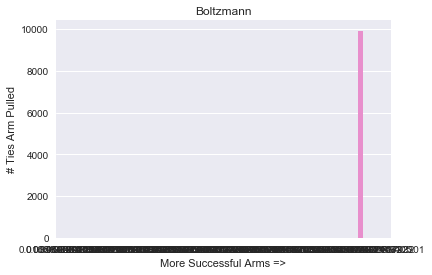

In [14]:
sns.barplot(x=sorted(BB.parameters),
            y=np.apply_along_axis(sum, 1, outcomes)[np.argsort(BB.parameters)])
plt.xlabel("More Successful Arms =>")
plt.ylabel("# Ties Arm Pulled")
plt.title("Boltzmann")

In [15]:
regret(BB.parameters, outcomes)

0.12904682230058362

## UCB1 approach
[source](http://www.yisongyue.com/courses/cs159/lectures/mab.pdf)

In [16]:
outcomes, path, rewards["ucb1"] = ucb1_policy(BB, N_PLAYS)

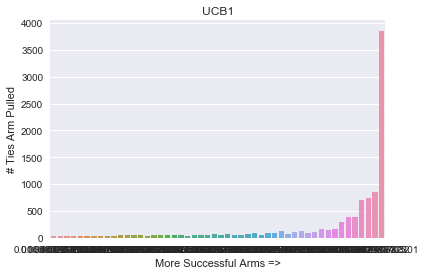

In [17]:
sns.barplot(x=sorted(BB.parameters),
            y=np.apply_along_axis(sum, 1, outcomes)[np.argsort(BB.parameters)])
plt.xlabel("More Successful Arms =>")
plt.ylabel("# Ties Arm Pulled")
plt.title("UCB1")

Compared to the $\epsilon$-greedy approach, it looks like we did a lot more exploration

In [18]:
regret(BB.parameters, outcomes)

0.15624682230058362

# Thompson Sampling

In [19]:
outcomes, path, rewards["thompson"]= thompson_policy(BB, N_PLAYS)

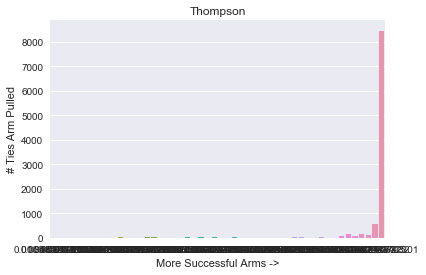

In [20]:
sns.barplot(x=sorted(BB.parameters),
            y=np.apply_along_axis(sum, 1, outcomes)[np.argsort(BB.parameters)])
plt.xlabel("More Successful Arms ->")
plt.ylabel("# Ties Arm Pulled")
plt.title("Thompson")

In [21]:
regret(BB.parameters, outcomes)

0.027746822300583607

# Head to head

(100, 10000)

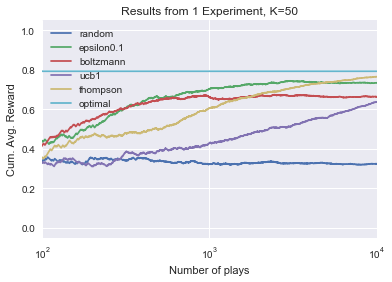

In [22]:
optimal = [max(BB.get_parameters())] * N_PLAYS
for policy in rewards:
    plt.plot(cummean(rewards[policy]),
             label=policy)
plt.plot(cummean(optimal),
         label="optimal")
plt.xlabel("Number of plays")
plt.ylabel("Cum. Avg. Reward")
plt.legend()
plt.title("Results from 1 Experiment, K=%d" % BB.get_K())
plt.xscale("log")
plt.xlim((BB.get_K() * 2, N_PLAYS))

Now that we've illustrated each policy on a single bandit, let's see how they do on average

In [23]:
def run_experiment(seed):
    np.random.seed(seed)
    BB = BinaryBandit(K=50)
    n_plays = 10000
    outcomes = [random_policy(BB, n_plays),
               epsilon_greedy_policy(BB, n_plays, 0.1),
               boltzmann_policy(BB, n_plays, temp),
               ucb1_policy(BB, n_plays),
               thompson_policy(BB, n_plays)
               ]
    return [regret(BB.get_parameters(), out[0]) for out in outcomes]

In [24]:
%%time
N_EXPERIMENTS = 100
P = Pool(7)
seeds = np.random.choice(range(1000000), N_EXPERIMENTS, replace=False)
regrets = P.map(run_experiment, seeds)

CPU times: user 375 ms, sys: 103 ms, total: 478 ms
Wall time: 5min 38s


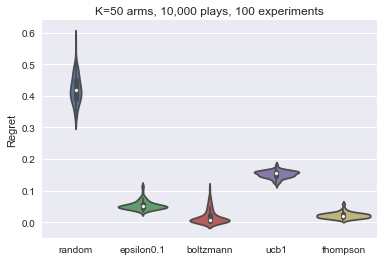

In [25]:
df_plot = \
pd.DataFrame(np.array(regrets)).\
rename(columns={0: "random",
                1: "epsilon0.1",
                2: "boltzmann",
                3: "ucb1",
                4: "thompson"})
sns.violinplot(x="variable", y="value",
               data=pd.melt(df_plot))
plt.ylabel("Regret")
plt.xlabel("")
plt.title("K=50 arms, 10,000 plays, %d experiments" % N_EXPERIMENTS)

In [26]:
df_plot.describe()

,random,epsilon0.1,boltzmann,ucb1,thompson
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.422370,0.054219,0.017396,0.152411,0.022492
std,0.044748,0.014273,0.021422,0.011540,0.009424
min,0.331334,0.033066,-0.000582,0.119553,0.008100
25%,0.391335,0.046198,0.004355,0.145931,0.015735
50%,0.418126,0.050880,0.007418,0.154356,0.021323
75%,0.451374,0.058596,0.023106,0.160360,0.027152
max,0.571503,0.114232,0.106426,0.181278,0.059313
